In [1]:
%%time
import sys, os
# import pickle
year = '2023'
path_gen = '/home/eliasmfs/Erasmus MC/Projects/CerebellarLoop'
path_data = f'/mnt/User_Data/UserData/eliasmfs/CerebellarLoop/SlowData/'
path_code = f'{path_gen}/Code/{year}/CerebellarLoop'
path_functions = f'{path_code}/Functions'
sys.path.append(path_data)
sys.path.append(path_functions)

from Run import *
from tqdm import tqdm
from scipy.signal import butter, lfilter, sosfiltfilt, find_peaks
import matplotlib.style as style 
style.use('seaborn-colorblind')


record = {}
record['Noise'] = True
record['PC'] = True
record['DCN'] = True
record['IO'] = True 
record['conn_N_PC'] = True
record['Input_presyn'] = True

save = 1
show = 0

noise_gain_range =  [1]

exp_run = 120000*ms
N_Cells_PC = 100
N_Cells_DCN = 40
N_Cells_IO = 40
N_Cells_PF = 5
plasticity_range = ['no_Plasticity','Plasticity','after_Plasticity']
coupling_range = ['','_Coupled']
zebrin_range = ['positive', 'negative']

# seed_number_range = []
# for num in range(10):
#     for N_Cells_PF_events in [0]:#0,1,2]:
#         N_Cells_PF_OU = N_Cells_PF - N_Cells_PF_events     
#         if N_Cells_PF_events == 0: 
#             CS_val = 0
#             US_val = 0
#             seed_number_range.append(f'Event_{num}_OU_{N_Cells_PF_OU}_Stim_{N_Cells_PF_events}_CS_{CS_val}_US_{US_val}')
#             continue
#         for CS_val in range(5,10,2):
#             for US_val in range(5,20,5):
#                 seed_number_range.append(f'Event_{num}_OU_{N_Cells_PF_OU}_Stim_{N_Cells_PF_events}_CS_{CS_val}_US_{US_val}')        

                
seed_number_range = []     
for num in range(2,3):
    seed_number_range.append(f'Paper_all_and_eyeblink')                  

seed_number = seed_number_range[0]

zebrin = zebrin_range[0]
noise_gain = 1

range_plasticity = ['Plasticity']
range_after_plasticity = ['after_Plasticity']

plas_range = 4
if plas_range > 1:
    for plas_num in range(2,plas_range+1):
        plasticity_range.append(f'Plasticity{plas_num}')
        range_plasticity.append(f'Plasticity{plas_num}')
        plasticity_range.append(f'after_Plasticity{plas_num}')
        range_after_plasticity.append(f'after_Plasticity{plas_num}')
        
f0_range = [0,5,10,15,20,25,50,100,800,1000,1100,1200,1300,1400,1500]

parameters_value = { "range_plasticity": range_plasticity, "range_after_plasticity": range_after_plasticity,
                    "PC_I_intrinsic": 0.15, "thresh_M": 60*Hz, "delta_weight_BCM": 0, "delta_weight_CS": -0.1,#-0.02

                    "unfiltered": True, "filtered": True, "f0_range": f0_range, "filter_order": 6, 
                    "positive":{
                        "Uncoupled":{'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.2, 'b_OU': -0.7, 
                                     'sigma_OU': 0.7},
                        'Coupled': {'w_IO_DCN': -2.0, 'PC_DCN': 5.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                    'sigma_OU': 0.7}},
                    'negative':{
                        'Uncoupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.3,
                                      'sigma_OU': 0.3},
                        'Coupled': {'w_IO_DCN': -1.8, 'PC_DCN': 4.0, 'leak': 0.001, 'gCal': 1.4, 'b_OU': -0.6, 
                                    'sigma_OU': 0.7}}}


Params, Noise_frozen, Values, Synaps, net_name = frozen_tun(seed_number_range,N_Cells_PC,N_Cells_DCN,N_Cells_IO,path_data,exp_run)
IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources

dt = Params['Seed_'+str(seed_number)].dt
dt_rec = float(Params['Seed_'+str(seed_number)].dt_rec)
time_x = [x * dt for x in range(0,int(exp_run/dt))]
time_x_rec = [x * dt for x in range(0,int(exp_run/dt_rec))]


coupling = '_Coupled'
plasticity = 'no_Plasticity'
f0 = 0

WARNING    <timed exec>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
 [py.warnings]



CPU times: user 31.1 s, sys: 8.38 s, total: 39.5 s
Wall time: 48.3 s


# Figure 3 - B

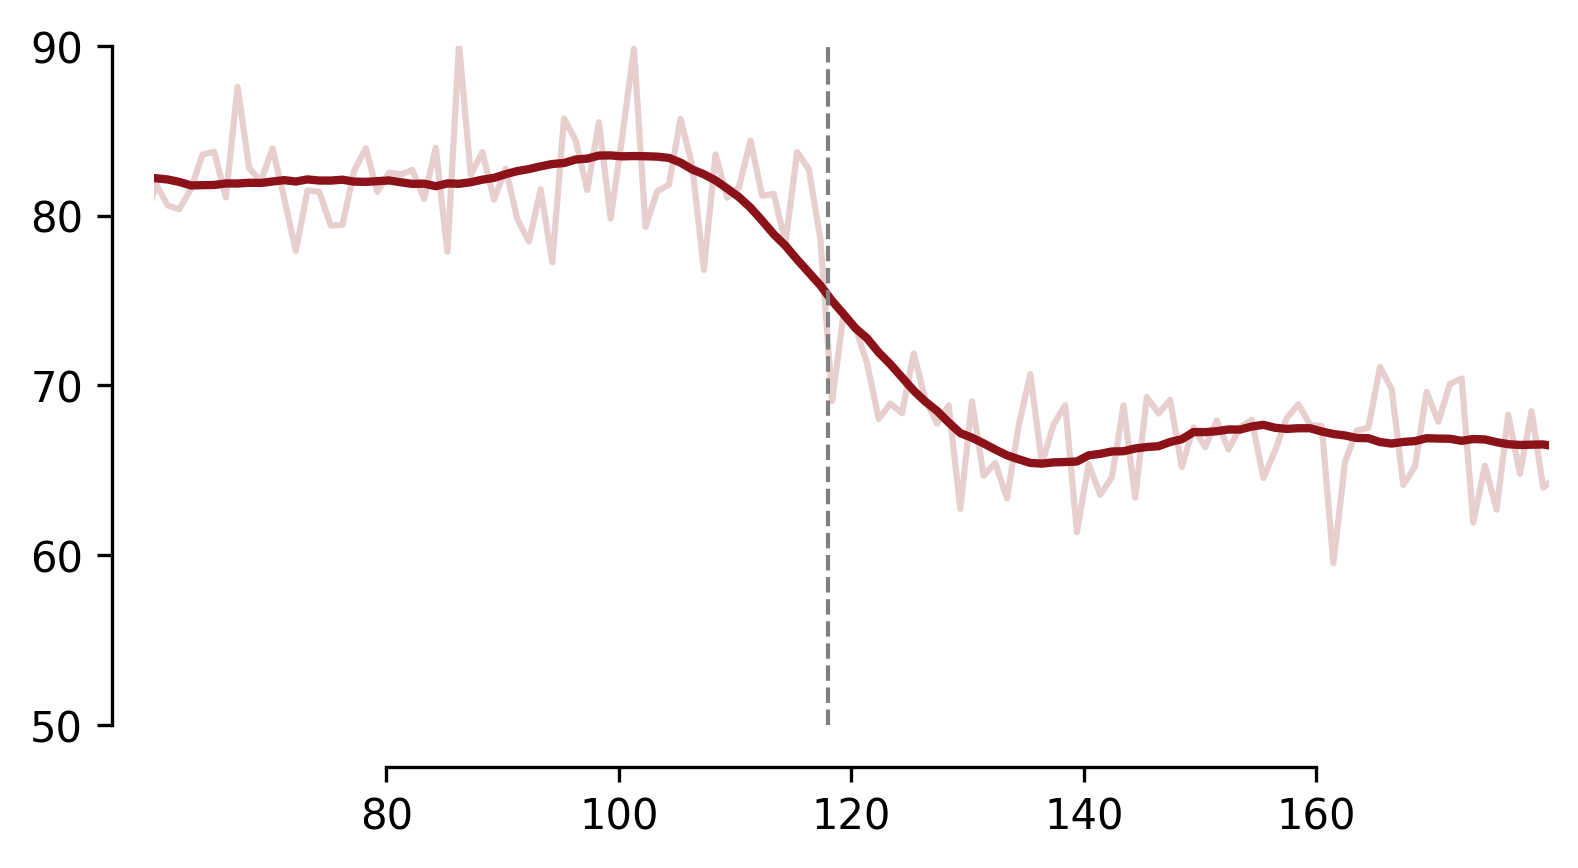

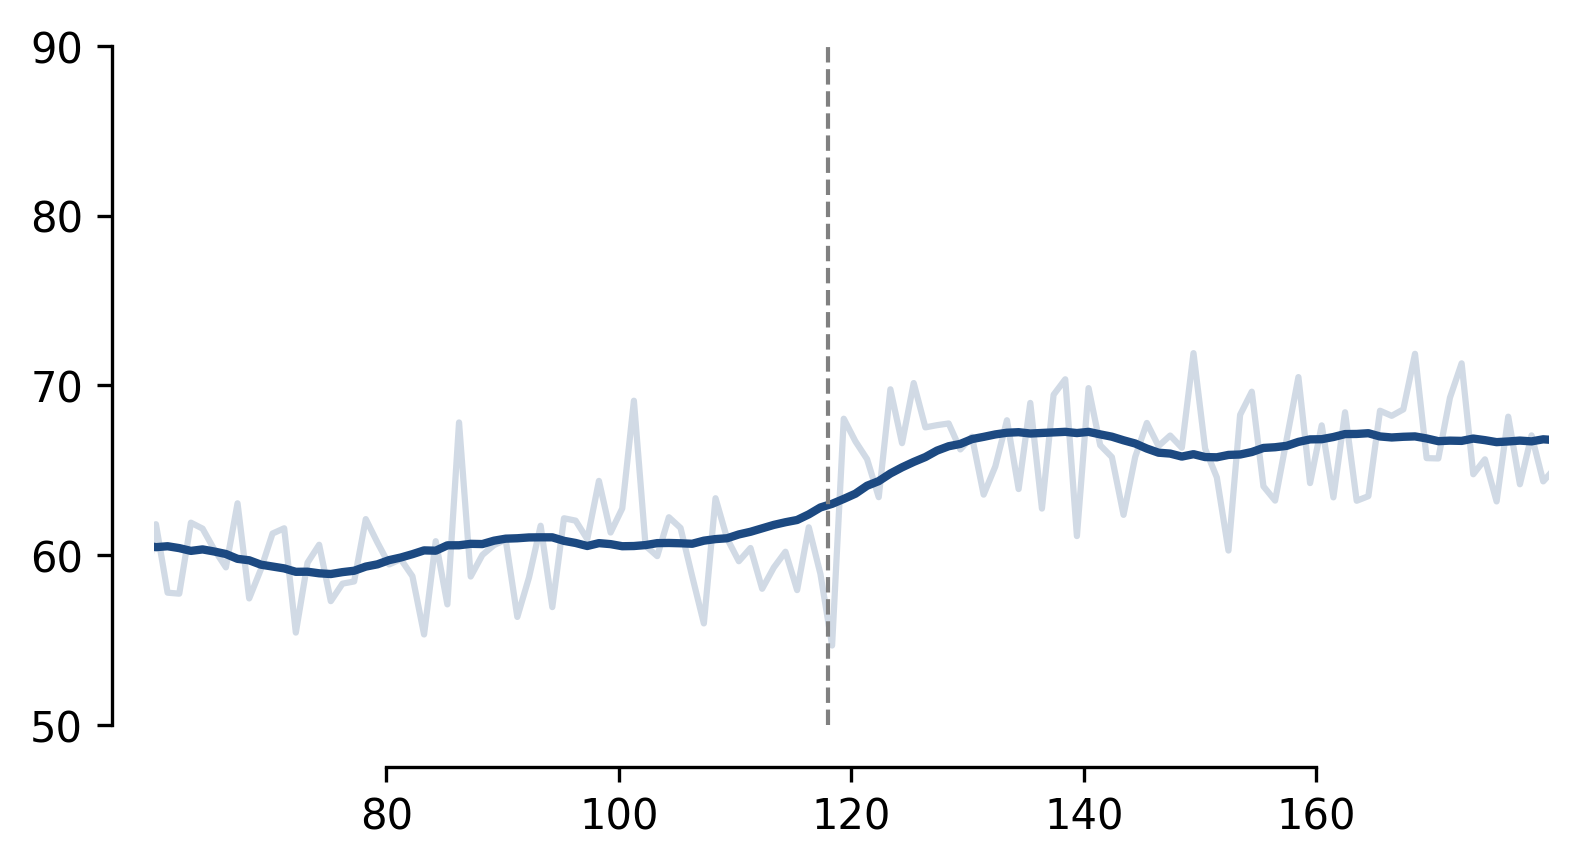

CPU times: user 1.61 s, sys: 4.15 s, total: 5.76 s
Wall time: 1.98 s


In [2]:
%%time
t_start = 1 * second
t_stop = 119 * second
bin_size = 1 * second
coupling = '_Coupled'
bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
f0 = 0
cell_num_range = dict(PC=N_Cells_PC,IO=N_Cells_IO)
colors = dict(positive='#1c4981',negative='#8a1218')

for row,cell_name in enumerate(['PC']):
#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 2),dpi=100,sharex = True,sharey=True)
    for zebrin in (['negative','positive']):
        average_firing_rate = []         
        figure(figsize=(6, 3),dpi=300)
        for plasticity in plasticity_range[0:3]:
            firing_rates = np.zeros((N_Cells_PC, int((t_stop-t_start)/bin_size)))
            for cell_num in range(cell_num_range[cell_name]):#PC_num_con:
                cell_spikes = output_load_run(f'{cell_name}_spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)[f'{cell_num}']
                spike_counts, _ = np.histogram(cell_spikes, bins=bin_edges)
                firing_rates[cell_num, :] = spike_counts / bin_size
            average_firing_rate = np.append(average_firing_rate, np.mean(firing_rates, axis=0))
        t = linspace(0,len(average_firing_rate),len(average_firing_rate))
        plot(t,average_firing_rate,colors[zebrin],alpha=0.2) 
        signala = average_firing_rate # with frequency of 100
        output_savgol = signal.savgol_filter(signala, 110, 9)
        plot(t,output_savgol,colors[zebrin],lw=2)
        axvline(len(average_firing_rate)/3, linestyle='--',color='grey',lw=1)
        axvline(len(average_firing_rate)*2/3, linestyle='--',color='grey',lw=1)
#         axes[1].set_yticks([])
        ylim([50,90])
        yticks(range(50,100,10))
        xlim(xmin = 60, xmax=180)
        xticks(range(80,170,20))
        sns.despine(trim=True,offset=10)
        plt.show()

# Figure 3 - C, D

In [3]:
%%time
names = {}
for plasticity in plasticity_range:
    if plasticity == 'no_Plasticity': names[f'{plasticity}'] = 'NP'
    elif plasticity == 'Plasticity': names[f'{plasticity}'] = 'P1'
    elif plasticity == 'Plasticity2': names[f'{plasticity}'] = 'P2'
    elif plasticity == 'Plasticity3': names[f'{plasticity}'] = 'P3'
    elif plasticity == 'Plasticity4': names[f'{plasticity}'] = 'P4'
    elif plasticity == 'after_Plasticity': names[f'{plasticity}'] = 'AP1'
    elif plasticity == 'after_Plasticity2': names[f'{plasticity}'] = 'AP2'
    elif plasticity == 'after_Plasticity3': names[f'{plasticity}'] = 'AP3'
    elif plasticity == 'after_Plasticity4': names[f'{plasticity}'] = 'AP4'

cell_pop_sizes = dict(PC=N_Cells_PC,IO=N_Cells_IO,DCN=N_Cells_DCN)



CPU times: user 11 µs, sys: 4 µs, total: 15 µs
Wall time: 23.1 µs


In [4]:
%%time
t_start = 1 * second
t_stop = 119 * second
bin_size = 1 * second
coupling = '_Coupled'
bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
f0 = 0
cell_num_range = dict(PC=N_Cells_PC,IO=N_Cells_IO)
data = []
for coupling in (['', '_Coupled']):
    for cell_name in ['PC','DCN','IO']:
        for zebrin in zebrin_range:
            for order,plasticity in enumerate(plasticity_range[0:1]):
                spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for cell_num in range(cell_pop_sizes[cell_name]):
                    spikes = spikes_output[f'{cell_num}']
                    bin_edges = np.arange(t_start, t_stop+bin_size, bin_size)
                    spike_counts, _ = np.histogram(spikes, bins=bin_edges)
                    mean_count = spike_counts / bin_size
                    row = dict(frequency = mean(mean_count/Hz))
                    row['cell'] = cell_name
                    row['plasticity'] = names[f'{plasticity}']
                    row['zebrin'] = zebrin
                    row['coupling'] = coupling
                    row['order'] = f'{order}'+names[f'{plasticity}']
                    data.append(row)
df_ff = pd.DataFrame(data)

CPU times: user 109 ms, sys: 12.6 ms, total: 122 ms
Wall time: 652 ms


Mann-Whitney u test
  Zebrin negative no_Plasticity
 U = 957.0, p = 0.0
Degree of freedom 1: 99
Degree of freedom 2: 99
f-test statistic: 0.9958500586186672
f-test p-value: 0.5082321765390673
Degree of freedom 1: 99
Degree of freedom 2: 99
t-test statistic: -13.778790904647632
t-test p-value: 9.94309590496524e-31


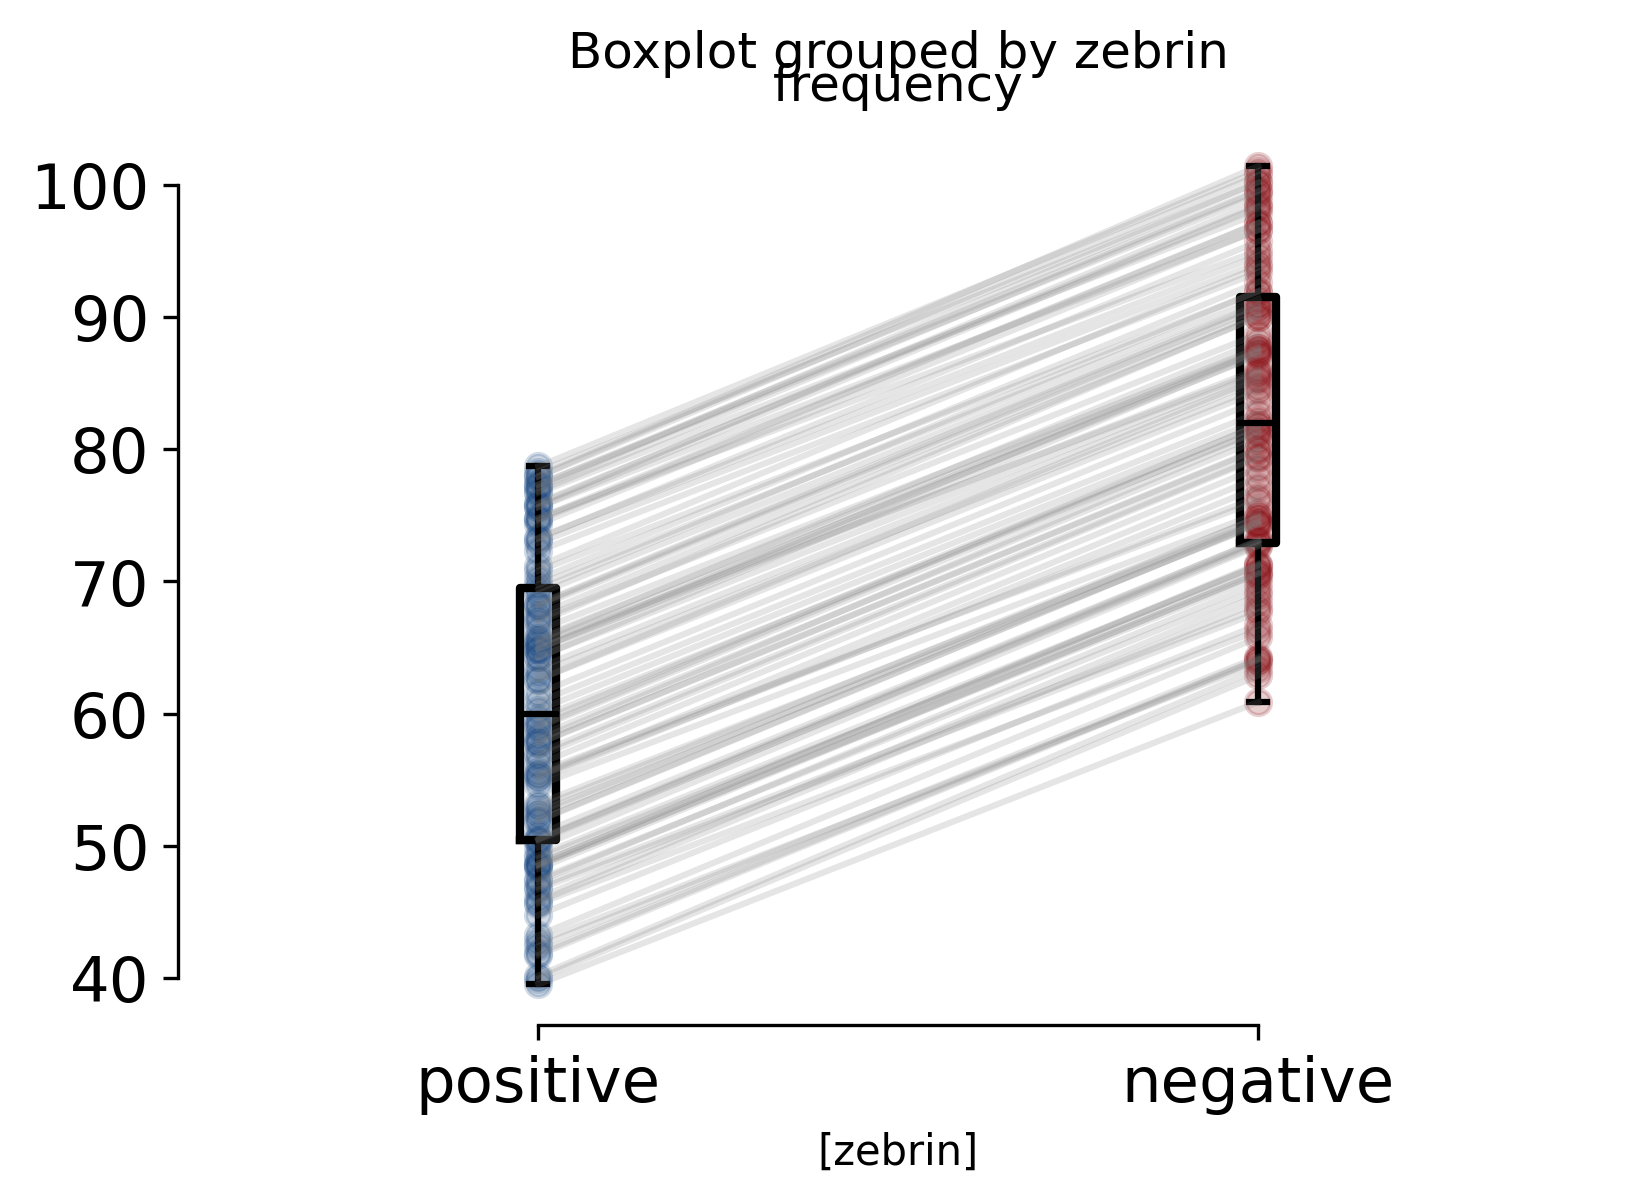

Mann-Whitney u test
  Zebrin negative no_Plasticity
 U = 363.0, p = 0.0
Degree of freedom 1: 39
Degree of freedom 2: 39
f-test statistic: 0.7430486829572075
f-test p-value: 0.8211518562598551
Degree of freedom 1: 39
Degree of freedom 2: 39
t-test statistic: -4.588695229363949
t-test p-value: 1.6781872700332024e-05


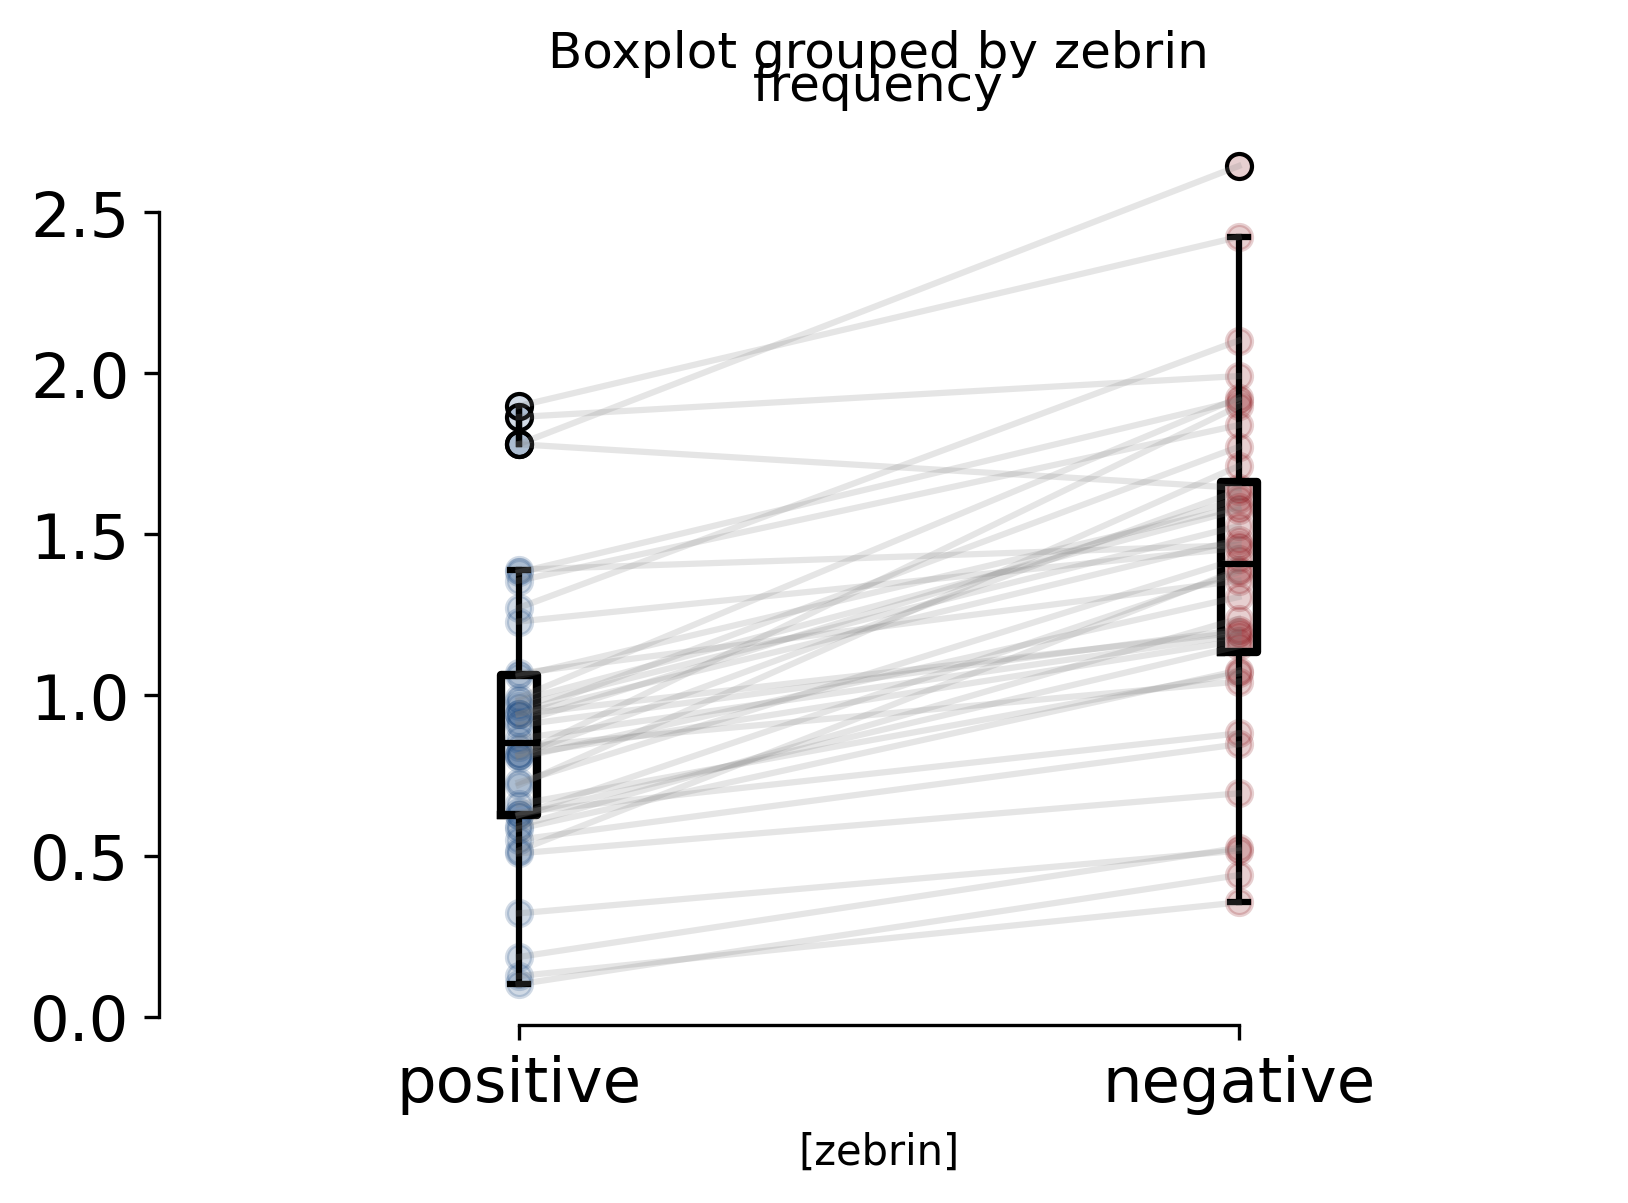

In [9]:
var = 'frequency'
zebrin_range = ['positive', 'negative']
for cell_name in ['PC','IO']:
    df_data = df_ff[(df_ff["coupling"]==coupling) & (df_ff["cell"]==cell_name)]
    Q1, Q3 = percentile(df_data['frequency'],[5,95])
    IQR = Q3 - Q1    #IQR is interquartile range. 
    lower_boundary = Q1 - 1.5 * IQR
    upper_boundary = Q3 + 1.5 * IQR
    df_data2 = df_data[(df_data[var] < upper_boundary) & (df_data[var] > lower_boundary)]
    fig = plt.figure(dpi=300)

    flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
    bp = df_data2.boxplot(column=var, by=['zebrin'], grid=False, figsize=(4,3), widths=0.05,fontsize=15,
                         color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                         boxprops=dict(linestyle='-', linewidth=2),
                         flierprops=dict(linestyle='-', linewidth=1.5),
                         medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                         whiskerprops=dict(linestyle='-', linewidth=1.5),
                         capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca(),positions=[2,1])  
    colors = dict(positive='#1c4981',negative='#8a1218')   
    x = {}
    y = {}
    for i,zebrin in enumerate(zebrin_range):
        y[f'{i}'] = df_data2.frequency[(df_data2.zebrin==zebrin) & (df_data2.plasticity==names[f'{plasticity}'])].dropna()
        x[f'{i}'] = [1+i]*len(y[f'{i}'])#rand_params(1+i, 1, len(y[f'{i}']), 0.007)#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
        scatter(x[f'{i}'], y[f'{i}'], color=f'{colors[zebrin]}', alpha=0.2)
    from scipy.stats import mannwhitneyu
    U1, p = mannwhitneyu(y['0'], y['1'], method="exact")
    print(f'Mann-Whitney u test\n  Zebrin {zebrin} {plasticity}\n U = {U1}, p = {round(p,3)}')
    import scipy.stats as stats
    variance1 = np.var(y['0'], ddof=1)
    variance2 = np.var(y['1'], ddof=1)
    f_value = variance1 / variance2
    df1 = len(y['0']) - 1
    df2 = len(y['1']) - 1
    p_value = stats.f.sf(f_value, df1, df2)
    print('Degree of freedom 1:',df1)
    print('Degree of freedom 2:',df2)
    print("f-test statistic:", f_value)
    print("f-test p-value:", p_value)
    from scipy.stats import ttest_ind
    t_stat, p_value = stats.ttest_ind(y['0'],y['1'])
    print('Degree of freedom 1:',df1)
    print('Degree of freedom 2:',df2)
    print("t-test statistic:", t_stat)
    print("t-test p-value:", p_value)
    toPlot = zip(x['0'], y['0'], x['1'], y['1'])
    for tuple in toPlot:
        plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'grey',alpha=0.2)
    xticks([1,2],zebrin_range)
#     if cell_name == 'PC':
#         yticks([30,60,90,120])
#     elif cell_name == 'IO':
#         yticks([0.5,1.0,1.5])
#         elif cell_name == 'DCN':
#             ylim([20,75])
    sns.despine(trim=True)
    plt.show()

# Figure 3 - E

In [6]:
%%time 

skip = 5*ms/second # seconds
transient_time = 10000
data = []
# 
for zebrin in zebrin_range:
    zeb_name = 'Z+'
    if zebrin == 'negative': zeb_name = 'Z-'
    for coupling in coupling_range:
        coup_name = 'Coup'
        if coupling == '': coup_name = 'Uncoup'
        for plasticity in plasticity_range[0:1]:
            plas_name = 'NP'
            if plasticity == 'Plasticity': plas_name = 'P'
            elif plasticity == 'after_Plasticity': plas_name = 'AP'
            IO_num_con = Synaps['Seed_'+str(seed_number)].IO_PC_Synapse_Sources
            IO_Spikes = output_load_run('IO_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
            PC_Spikes = output_load_run('PC_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
            for pc_cell_id in range(N_Cells_PC):
                pauses = []
                io_cell_id = IO_num_con[pc_cell_id]
                row = dict(PC=pc_cell_id)
                row['IO'] = io_cell_id
                for io_spike in IO_Spikes[f'{io_cell_id}']:
                    if io_spike < transient_time*ms/second: continue
                    hit = None
                    for pc_spike in PC_Spikes[f'{pc_cell_id}']:
                        if pc_spike <= io_spike+skip:
                            continue
                        hit = pc_spike
                        break
                    if hit is not None:
                        pauses.append((hit - io_spike))
                pauses = np.array(pauses)*1e3
                row['average_pause'] = mean(pauses)
                row['zebrin'] = zebrin
                row['plasticity'] = plasticity
                row['coupling'] = coupling
                data.append(row)
                
df_pauses = pd.DataFrame(data).dropna()


CPU times: user 33.7 s, sys: 40.5 ms, total: 33.7 s
Wall time: 37.4 s


Mann-Whitney u test
  Zebrin negative no_Plasticity
 U = 8947.0, p = 0.0
Degree of freedom 1: 99
Degree of freedom 2: 99
f-test statistic: 2.941549015474213
f-test p-value: 8.364538852635966e-08
Degree of freedom 1: 99
Degree of freedom 2: 99
t-test statistic: 12.523179036675948
t-test p-value: 7.006387230454337e-27


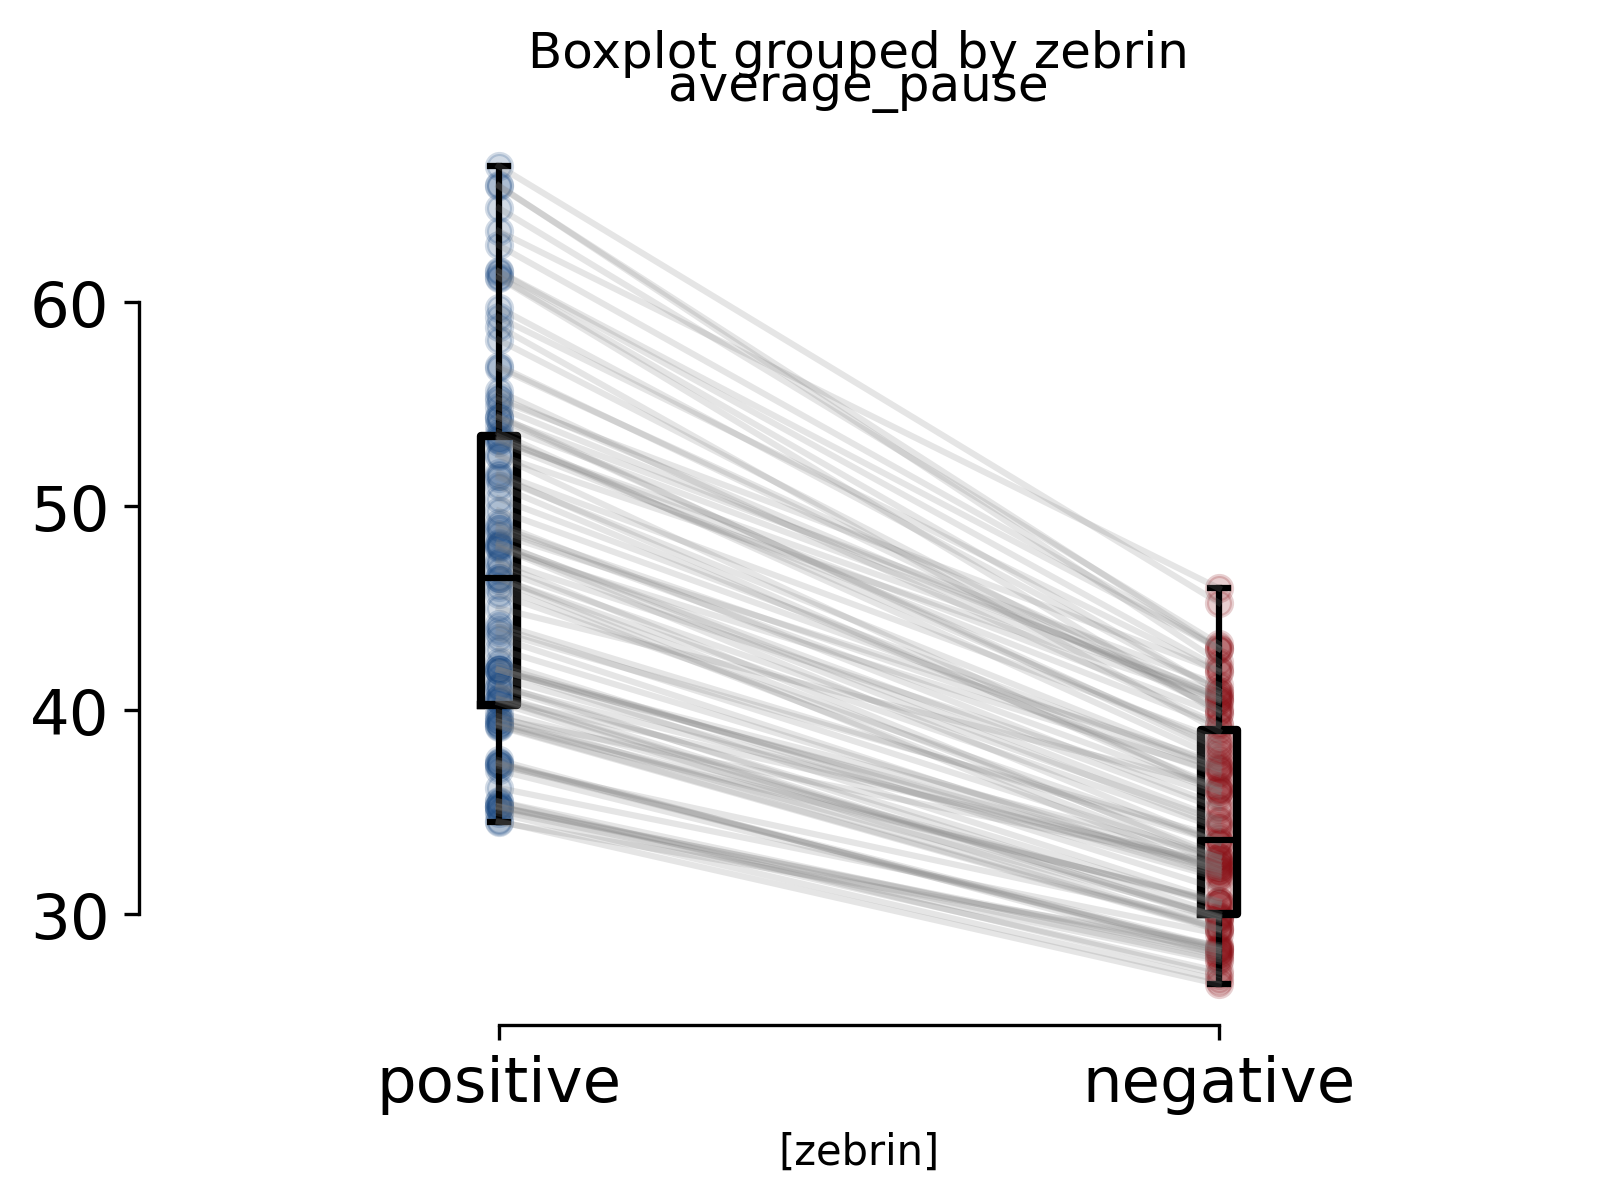

In [8]:
var = 'average_pause'
plasticity = 'no_Plasticity'
zebrin_range = ['positive', 'negative']
df_data = df_pauses[(df_pauses["coupling"]==coupling)]
Q1, Q3 = percentile(df_data['average_pause'],[5,95])
IQR = Q3 - Q1    #IQR is interquartile range. 
lower_boundary = Q1 - 1.5 * IQR
upper_boundary = Q3 + 1.5 * IQR
df_data2 = df_data[(df_data[var] < upper_boundary) & (df_data[var] > lower_boundary)]
fig = plt.figure(dpi=300)

flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
bp = df_data2.boxplot(column=var, by=['zebrin'], grid=False, figsize=(4,3), widths=0.05,fontsize=15,
                     color=dict(boxes='k', whiskers='k', medians='k', caps='k'),
                     boxprops=dict(linestyle='-', linewidth=2),
                     flierprops=dict(linestyle='-', linewidth=1.5),
                     medianprops=dict(linestyle='-', linewidth=1.5, color = 'k'),
                     whiskerprops=dict(linestyle='-', linewidth=1.5),
                     capprops=dict(linestyle='-', linewidth=1.5),ax = plt.gca(),positions=[2,1])  
colors = dict(positive='#1c4981',negative='#8a1218')   
x = {}
y = {}
for i,zebrin in enumerate(zebrin_range):
    y[f'{i}'] = df_data2.average_pause[(df_data2.zebrin==zebrin)].dropna()
    x[f'{i}'] = [1+i]*len(y[f'{i}'])#rand_params(1+i, 1, len(y[f'{i}']), 0.007)#np.random.normal(1+j+(len(plasticity_range[0:1]))*i, 0.12, size=len(y))    # Add some random "jitter" to the x-axis
    scatter(x[f'{i}'], y[f'{i}'], color=f'{colors[zebrin]}', alpha=0.2)
from scipy.stats import mannwhitneyu
U1, p = mannwhitneyu(y['0'], y['1'], method="exact")
print(f'Mann-Whitney u test\n  Zebrin {zebrin} {plasticity}\n U = {U1}, p = {round(p,3)}')
import scipy.stats as stats
variance1 = np.var(y['0'], ddof=1)
variance2 = np.var(y['1'], ddof=1)
f_value = variance1 / variance2
df1 = len(y['0']) - 1
df2 = len(y['1']) - 1
p_value = stats.f.sf(f_value, df1, df2)
print('Degree of freedom 1:',df1)
print('Degree of freedom 2:',df2)
print("f-test statistic:", f_value)
print("f-test p-value:", p_value)
from scipy.stats import ttest_ind
t_stat, p_value = stats.ttest_ind(y['0'],y['1'])
print('Degree of freedom 1:',df1)
print('Degree of freedom 2:',df2)
print("t-test statistic:", t_stat)
print("t-test p-value:", p_value)
toPlot = zip(x['0'], y['0'], x['1'], y['1'])
for tuple in toPlot:
    plot([tuple[0], tuple[2]], [tuple[1], tuple[3]], color=f'grey',alpha=0.2)
xticks([1,2],zebrin_range)
# yticks([20,40,60])
sns.despine(trim=True)
plt.show()

# Figure 3 - Extra

In [ ]:
%%time
data = []
for coupling in (['', '_Coupled']):
    for cell_name in ['PC','DCN','IO']:
        for zebrin in zebrin_range:
            for plasticity in plasticity_range:
                spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for cell_num in range(cell_pop_sizes[cell_name]):
                    isi_arr = np.diff(spikes_output[f'{cell_num}'])*1000
                    for isi in isi_arr:
                        row = dict(isi = isi)
                        row['cell'] = cell_name
                        row['plasticity'] = names[f'{plasticity}']
                        row['zebrin'] = zebrin
                        row['coupling'] = coupling
                        data.append(row)
df_isi = pd.DataFrame(data)

zebrin_range = ['negative','positive']
for coupling in (['_Coupled']):#, '']):
    df_data1 = df_isi[(df_isi["coupling"]==coupling)]
    for cell_name in ['IO']:#['PC','IO','DCN']:
        df_data = df_data1[(df_data1["cell"]==cell_name)]
        for plasticity in plasticity_range[0:1]:
            df_data = df_data[(df_data["plasticity"]==names[f'{plasticity}'])]
            Q1, Q3 = percentile(df_data['isi'],[25,75])
            IQR = Q3 - Q1    #IQR is interquartile range. 
            lower_boundary = Q1 - 1.5 * IQR
            upper_boundary = Q3 + 1.5 * IQR
            df_data2 = df_data[(df_data['isi'] < upper_boundary) & (df_data['isi'] > lower_boundary)]
            
            figure(figsize=(5,5),dpi=100)
            title(f'ISI {cell_name}{coupling}')
            bin_w = (df_data[['isi']].mean().item()/50)
            sns.histplot(data=df_data2, x="isi", hue="zebrin",binwidth=bin_w,
                       palette={"positive": "b", "negative": "r"})
            y_axx = 10000 
            if cell_name == 'IO': y_axx = 250
            elif cell_name == 'DCN': y_axx = 2500
            colors = dict(positive='#1c4981',negative='#8a1218')
            for zebrin in zebrin_range:
                mean_val = df_data[df_data['zebrin']==zebrin]["isi"].mean()
                axvline(x=mean_val,color=colors[zebrin],lw=2)
                text(mean_val+bin_w,y_axx,f'{round(mean_val)}ms',color=colors[zebrin],rotation=45)
#             for patch in ax.collections:
#                 patch.set_alpha(0.5)
#             xlim([0,int(mean_val*2)])
            xlabel('ISI [ms]')
            sns.despine(trim=True)
            plt.show()
            
            Q1, Q3 = percentile(df_data['isi'],[25,75])
            IQR = Q3 - Q1    #IQR is interquartile range. 
            lower_boundary = Q1 - 1.5 * IQR
            upper_boundary = Q3 + 1.5 * IQR
            df_data2 = df_data[(df_data['isi'] < upper_boundary) & (df_data['isi'] > lower_boundary)]
            
            flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
            bp = df_data2.boxplot(column='isi', by='zebrin', grid=False,figsize=(4,6), fontsize=15,flierprops = flierproperties,)  
            title(f'ISI {plasticity}{coupling}')
            colors = dict(positive="#1c4981",negative='#8a1218')
            for i,zebrin in enumerate(zebrin_range):
                y = df_data2.isi[df_data.zebrin==zebrin].dropna()
                x = np.random.normal(i+1, 0.04, size=len(y))    # Add some random "jitter" to the x-axis
#                 plot(x, y, colors[zebrin], alpha=0.01)
                scatter(x, y, color=colors[zebrin], alpha=0.01)
            xticks(range(1,1+len(zebrin_range)),zebrin_range)
            plt.ylabel("ISI [ms]")
            sns.despine(trim=True)
            plt.show()
# dict(positive='#1c4981',negative='#8a1218')
#             boxproperties = dict(linestyle='-', linewidth=2.5)
#             medianproperties = dict(linestyle='-', linewidth=2.5)
#             flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
#             colors = dict(boxes='dimgrey', whiskers='darkgray', medians='yellowgreen', caps='dimgrey')
#             df_data2.plot.box(column='isi', by='zebrin',grid=False, patch_artist=True, showmeans = True,
#                         sym='.', color = colors, boxprops=boxproperties,
#                         medianprops=medianproperties, flierprops = flierproperties,
#                         figsize=(4, 6))
#             colors = dict(positive='b',negative='r')
#             for i,zebrin in enumerate(zebrin_range):
#                 y = df_data2.isi[df_data.zebrin==zebrin].dropna()
#                 x = np.random.normal(i+1, 0.04, size=len(y))    # Add some random "jitter" to the x-axis
#                 plot(x, y, f'{colors[zebrin]}.', alpha=0.01)
#             plt.title(f'ISI {plasticity}{coupling}')
#             plt.ylabel("ISI [ms]")
#             plt.xlabel("Zebrin") 
#             xticks(range(1,1+len(zebrin_range)),zebrin_range)              
#             sns.despine(trim=True)
#             plt.show()  

In [ ]:
%%time 
from scipy.stats import variation
zebrin_range = ['negative','positive']
data = []
for coupling in (['', '_Coupled']):
    for cell_name in ['PC','DCN','IO']:
        for zebrin in zebrin_range:
            for plasticity in plasticity_range:
                spikes_output = output_load_run(f'{cell_name}_Spikes',coupling,seed_number,plasticity,zebrin,noise_gain,exp_run,net_name,path_data,parameters_value,f0)
                for cell_num in range(cell_pop_sizes[cell_name]):
                    cv_arr = variation(spikes_output[f'{cell_num}'], axis=0)
                    row = dict(cv = cv_arr)
                    row['cell'] = cell_name
                    row['plasticity'] = names[f'{plasticity}']
                    row['zebrin'] = zebrin
                    row['coupling'] = coupling
                    data.append(row)
df_cv = pd.DataFrame(data)

for coupling in (['_Coupled']):#, '']):
    df_data1 = df_cv[(df_cv["coupling"]==coupling)]
    for cell_name in ['IO']:#['PC','IO','DCN']:
        df_data = df_data1[(df_data1["cell"]==cell_name)]
        for plasticity in plasticity_range[0:1]:
            df_data = df_data[(df_data["plasticity"]==names[f'{plasticity}'])]
            figure(figsize=(5,5),dpi=100)
            title(f'CV {cell_name}{coupling}')
            bin_w = (df_data[['cv']].mean().item()/50)
            if cell_name == 'PC': bin_w = .1
            sns.histplot(data=df_data, x="cv", hue="zebrin",binwidth=bin_w,
                       palette=dict(positive='#1c4981',negative='#8a1218'))
            y_axx = 5 
            colors = dict(positive='#1c4981',negative='#8a1218')
            for ii,zebrin in enumerate(zebrin_range):
                mean_val = df_data[df_data['zebrin']==zebrin]["cv"].mean()
                axvline(x=mean_val,color=colors[zebrin],lw=2)
                text(mean_val+bin_w,y_axx+ii*2,f'Mean: {round(mean_val,2)}',color=colors[zebrin],rotation=45)
#             for patch in ax.collections:
#                 patch.set_alpha(0.5)
            xmin = -int(mean_val*2)
            xmax = int(mean_val*2)
            if xmin<0:xmin=0
            if cell_name == 'PC': 
                xmin=.55
                xmax=.62
            xlim([xmin,xmax])
            xlabel('CV')
            sns.despine(trim=True)
            plt.show()
            
            Q1, Q3 = percentile(df_data['cv'],[5,95])
            IQR = Q3 - Q1    #IQR is interquartile range. 
            lower_boundary = Q1 - 1.5 * IQR
            upper_boundary = Q3 + 1.5 * IQR
            df_data2 = df_data[(df_data['cv'] < upper_boundary) & (df_data['cv'] > lower_boundary)]
            
            flierproperties = dict(markerfacecolor = 'white', markeredgecolor = 'white')
            bp = df_data2.boxplot(column='cv', by='zebrin', grid=False,figsize=(4,6), fontsize=15,flierprops = flierproperties,)  
            title(f'CV2 {cell_name} {plasticity}{coupling}')
            colors = dict(positive='#1c4981',negative='#8a1218')
            for i,zebrin in enumerate(zebrin_range):
                y = df_data.cv[df_data.zebrin==zebrin].dropna()
                x = np.random.normal(i+1, 0.04, size=len(y))    # Add some random "jitter" to the x-axis
                scatter(x, y, color=colors[zebrin], alpha=0.1)
            xticks(range(1,1+len(zebrin_range)),zebrin_range)
            plt.ylabel("CV")
            sns.despine(trim=True)
            plt.show()
            